In [243]:
import numpy             as np
import matplotlib.pyplot as plt 
import scipy.special     
import os
import glob
from   GDa.io   import read_mat, set_paths

#### Class to load session trial and recording info

In [144]:
class session_info():
    
    def __init__(self, raw_path = 'GrayLab/', monkey = 'lucy', date = '150128', session = 1):
        #Check for incorrect parameter values
        if monkey not in ['lucy', 'ethyl']:
            raise ValueError('monkey should be either "lucy" or "ethyl"')
        # Class atributes
        self.monkey  = monkey
        self.date    = date
        self.session = 'session0' + str(session)
        # Creating paths to load and save data
        self.__paths    = set_paths(raw_path = raw_path, monkey = monkey, date = date, session = session)
        # To load .mat files
        self.__load_mat = read_mat()
        # Actually read the info
        self.__read_session_info()
        
    def __read_session_info(self, ):
        # Recording and trial info
        info = ['recording_info.mat', 'trial_info.mat'] 
        ri   = self.__load_mat.read_mat(os.path.join(self.__paths.dir,info[0]) )['recording_info']
        ti   = self.__load_mat.read_HDF5(os.path.join(self.__paths.dir,info[1]) )['trial_info']
        # Storing the recording and trial infor into dictionaries
        self.trial_info     = {}
        self.recording_info = {}
        for key in ri._fieldnames:
            self.recording_info[key] = np.squeeze(ri.__dict__[key])
        for key in ti.keys():
            self.trial_info[key] = np.squeeze(ti[key])
    
    def print_paths(self, ):
        print('dir: ' + self.__paths.dir)
        print('dir_out: ' + self.__paths.dir_out)

#### Instantiate class and check the information

In [145]:
si = session_info(raw_path = 'GrayLab/', monkey = 'lucy', date = '150128', session = 1)

We can now check which are the trial and recording information stored in 'recording_info.mat' and 'trial_info.mat'. As Steve said in recording info we should have:

#### Recording info:
- image_locations: x,y location of images in degrees;
- image_names: names of the images;
- image_data: rgb matrices;
- channel_count: number of electrodes used during recording session;
- channel_numbers: electrode number;
- area: cell array containing the cortical area each electrode was in during recording session;
- depth: depth of each electrode during recording session;
- raw_data_sampling_rate: sampling rate of raw data
- calib_eye_sampling_rate: sampling rate of the eye data from Monkey Logic software
- number_sua: this is the number of single units on each electrode (note: all channels have mua);

#### Trial info:

- trial_type: 1 match-to-sample, 2 interleaved fixation trials, 3 blocked fixation trials, and 4 blank trials;
- sample_on: time that sample image was turned on (milliseconds);
- sample_off: time that sample image was turned off (milliseconds);
- match_on: time that the matching image and a distractor image are turned on (fixation point is simultaneously turned off);
- reaction_time: time taken for animal to make a saccade to the matching image;
- sample_image: number identifying which image was used for the sample;
- sample_location: number identifying the location of the sample image;
- match_image: number identifying the image that corresponds to the sample_image;
- match_location: number identifying the location of the matching image;
- nonmatch_image: number identifying the image that is not the matching image;
- nonmatch_location: number identifying the location of the non matching image;
- behavioral_response: 0 incorrect, 1 correct;
- num_trials: number of trials performed;

Let's print the keys of the dictionaries to check

In [146]:
print('Recording informations:\n')
print(si.recording_info.keys())

Recording informations:

dict_keys(['image_locations', 'image_names', 'image_data', 'channel_count', 'channel_numbers', 'area', 'depth', 'lfp_sampling_rate', 'calib_eye_sampling_rate', 'number_sua', 'ms_mod', 'slvr'])


In [147]:
print('Trial informations:\n')
print(si.trial_info.keys())

Trial informations:

dict_keys(['behavioral_response', 'match_image', 'match_location', 'match_on', 'nonmatch_image', 'nonmatch_location', 'num_trials', 'reaction_time', 'sample_image', 'sample_location', 'sample_off', 'sample_on', 'trial_type'])


#### Class to load the LFP data

In [277]:
class session(session_info):
    
    def __init__(self, raw_path = 'GrayLab/', monkey = 'lucy', date = '150128', session = 1,
                 slvr_msmod = False, align_to = 'cue', trial_type = 1, 
                 behavioral_response = None, evt_dt = [-0.65, 3.00]):
        #Check for incorrect parameter values
        if monkey not in ['lucy', 'ethyl']:
            raise ValueError('monkey should be either "lucy" or "ethyl"')
            
        if align_to not in ['cue', 'match']:
            raise ValueError('align_to should be either "cue" or "match"')
            
        if behavioral_response not in [0, 1, None]:
            raise ValueError('s_type should be either 0 (correct), 1 (incorrect) or None (both)')
            
        if trial_type not in [1, 2, 3, 4]:
            raise ValueError('trial_type should be either 1 (DRT), 2 (intervealed fixation), 3 (blocked fixation) or 4 (blank trials)')       
        
        # Instantiating father class session_info
        super().__init__(raw_path = raw_path, monkey = monkey, date = date, session = session)
        
        # Creating paths to load and save data
        self.__paths    = set_paths(raw_path = raw_path, monkey = monkey, date = date, session = session)
        self.__load_mat = read_mat()
        
        # Storing class atributes
        self.slvr_msmod = slvr_msmod
        self.trial_type = trial_type
        self.evt_dt     = evt_dt
        self.align_to   = align_to
        self.behavioral_response = behavioral_response
        
        # Atually reads the data
        self.__read_lfp_data()
        
    def __read_lfp_data(self, ):
        
        # Get file names
        files = sorted(glob.glob( os.path.join(self.__paths.dir, self.date+'*') ))
        # Cue onset/offset and match onset times
        t_con   = self.trial_info['sample_on']
        t_coff  = self.trial_info['sample_off']
        t_mon   = self.trial_info['match_on']
        
        # Choose if is aligned to cue or to match
        if self.align_to == 'cue':
            t0 = t_con
        elif self.align_to == 'match':
            t0 = t_mon
        
        # Channels index array
        indch   = np.arange(self.recording_info['channel_count'], dtype = int)
        # Exclude channels with short latency visual respose (slvr) and microsacade modulation (ms_mod)
        if self.slvr_msmod == False:
            idx_slvr_msmod = (self.recording_info['slvr'] == 0) & (self.recording_info['ms_mod'] == 0)
            indch          = indch[idx_slvr_msmod]
        # Selecting trials
        if self.behavioral_response is not None:
            indt_idx = (self.trial_info['trial_type'] == self.trial_type) & (self.trial_info['behavioral_response'] == self.behavioral_response)
            indt = np.arange(self.trial_info['num_trials'], dtype=int)[indt_idx]
        else:
            indt_idx = self.trial_info['trial_type'] == self.trial_type
            indt = np.arange(self.trial_info['num_trials'], dtype=int)[indt_idx]
        
        # Number of trials selected
        n_trials = len(indt)
        # Number of time points
        n_times  = int( self.recording_info['lfp_sampling_rate'] * (self.evt_dt[1]-self.evt_dt[0]) )
        # Number of channels selected
        n_channels = len(indch)
        
        # Tensor to store the LFP data NtrialsxNchannelsxTime
        self.data = np.empty([n_trials, n_channels, n_times]) # LFP data
        # Time array
        self.time = np.arange(self.evt_dt[0], self.evt_dt[1], 1/self.recording_info['lfp_sampling_rate'])
        #self.time = np.empty([n_trials, n_times])             # Time vector for each trial
        
        # For each selected trial
        for i,nt in zip(range(len(indt)), indt):
            f        = self.__load_mat.read_HDF5(files[nt])
            lfp_data = np.transpose( f['lfp_data'] )
            # Beggining and ending time index for this t0
            indb     = int(t0[nt] + self.recording_info['lfp_sampling_rate']*self.evt_dt[0])
            inde     = int(t0[nt] + self.recording_info['lfp_sampling_rate']*self.evt_dt[1])
            # Time index array
            ind      = np.arange(indb, inde+1, dtype = int)
            # LFP data, dimension NtrialsxNchannelsxTime
            self.data[i] = lfp_data[indch, indb:inde]
            
        # Stimulus presented for the selected trials 
        stimulus = self.trial_info['sample_image'][indt]
        # Labels of the selected channels
        labels   = self.recording_info['channel_numbers'][indch]
        # Number of possible pairs (undirected network)
        nP       = int( scipy.special.comb(n_channels, 2) )
        # Every pair combination
        i, j     = np.tril_indices(n_channels)
        pairs    = np.array([i,j]).T
        # Area names for selected channels 
        area     = self.recording_info['area'][indch]
        # Store to dictionary
        self.read_info = {'nC': n_channels, 'nP':nP, 'nT':n_trials, 'pairs': pairs,
                         'indt': indt, 'fsample': self.recording_info['lfp_sampling_rate'],
                         'tarray': self.time, 'channels_labels': labels, 'stim':stimulus,
                         'indch': indch, 'areas': area, 't_cue_on': t_con[indt] ,
                         't_cue_off': t_coff[indt], 't_match_on': t_mon[indt]
                         }



In [276]:
s = session(raw_path = 'GrayLab/', monkey = 'lucy', date = '150128', session = 1,
            slvr_msmod = False, align_to = 'cue', trial_type = 1, 
            behavioral_response = 1, evt_dt = [-0.65, 3.00])

(56, 5676)
(56, 5817)
(56, 5878)
(56, 5605)
(56, 5508)
(56, 5597)
(56, 5320)
(56, 5677)
(56, 5567)
(56, 5626)
(56, 5644)
(56, 5452)
(56, 5759)
(56, 5712)
(56, 5679)
(56, 5453)
(56, 5562)
(56, 5535)
(56, 5707)
(56, 5492)
(56, 5444)
(56, 5546)
(56, 5686)
(56, 5572)
(56, 5786)
(56, 5928)
(56, 5680)
(56, 5745)
(56, 5752)
(56, 5625)
(56, 5824)
(56, 5833)
(56, 5493)
(56, 5613)
(56, 5319)
(56, 5363)
(56, 5798)
(56, 5466)
(56, 5680)
(56, 5612)
(56, 5493)
(56, 5505)
(56, 5852)
(56, 5473)
(56, 5988)
(56, 5646)
(56, 5774)
(56, 5672)
(56, 5797)
(56, 5730)
(56, 5719)
(56, 5906)
(56, 5741)
(56, 5693)
(56, 5305)
(56, 5500)
(56, 5598)
(56, 5807)
(56, 5491)
(56, 5360)
(56, 5355)
(56, 5560)
(56, 5920)
(56, 5694)
(56, 5492)
(56, 5705)
(56, 5439)
(56, 5519)
(56, 5425)
(56, 5305)
(56, 5263)
(56, 5772)
(56, 5471)
(56, 5746)
(56, 5745)
(56, 5639)
(56, 5358)
(56, 5438)
(56, 5479)
(56, 5606)
(56, 5490)
(56, 5593)
(56, 5478)
(56, 5346)
(56, 5532)
(56, 5532)
(56, 5384)
(56, 5399)
(56, 5505)
(56, 5509)
(56, 5692)

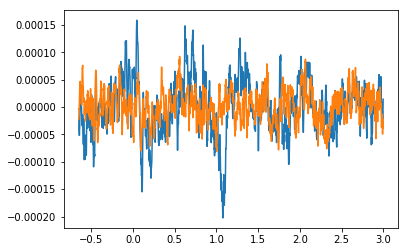

In [257]:
plt.plot(s.time, s.data[0,0,:])
plt.plot(s.time, s.data[0,10,:])

In [246]:
np.tril_indices(49)

(array([ 0,  1,  1, ..., 48, 48, 48]), array([ 0,  0,  1, ..., 46, 47, 48]))